# Principle Component Analysis

version 
- 1 23/2/2018. Wing-Fai Thi
- 2 8/5/2024 wing-Fai Thi, update to Python 3

How feature engineering using PCA can improve classification accuracy?

### Summary of PCA characteristics:
- PCA is an unsupervised learning method
- the eigenvectors (principal components) of a covariance  matrix  determine the directions of the new feature space, and the eigenvalues determine their magnitude.
- a correlation matrix can be used instead because the correlation matrix can be understood as the normalized covariance matrix.
- geometrically the PCA transformation from data axes to principal axes is an affine transformation, composed of a translation, rotation, and uniform scaling.
- PCA components explain the variance in the data in decreasing importance. The principal component (1st component) points in the direction of the largest variance. Each subsequent component is orthogonal to the previous ones, and points in the directions of the largest variance of the residual subspace.
- if the data are linearly correlated, the PCA components will be uncorrelated.
- to compute the PCA: use standardized data to generate covariance matrix or correlation matrix. Compute the eigen vectors that are the principal component, which will give the direction and compute eigen values, which will give the magnitude.
- practically the transform is performed through a Singular Value Decomposition. SVD is a linear algebra method that decomposes a matrix into three resultant matrices.
- No hyper-parameter is required.
- a PCA transform is also called the Karhunen-Loeve transform

<img src="PCA.png" />

### Usages of PCA:
- dimensionality reduction. The first few components can explain most of the variance in the data
- find unseen relationships between features
- noise reduction. Compared to the actual data, the noise variance is small
- outliers are also removed
- feature engineering. Feature engineering uses our knowledge of the problem to choose features or create new features that allow machine learning algorithms to work more accurately. One can analyse the transformed features instead of the original ones.

### Principle use cases:
- Fraud detection (outlier detection)
- Spam detection
- Image recognition
- Speech recognition

### Limitations of PCA:
- the results of PCA depend on the scaling of the variables. 
- it tends to be highly affected by outliers in the data.
- it assumes that the relationships are linear. Otherwise, PCA-transformed features may still be correlated. 
- for classification, the first component may not bring the highest discrimnating power

### Related concepts:
- Kernel PCA: this method can deal with nonlinearity
- Independent Components Analysis (ICA)
- Factor Analysis (FA), also called Exploratory Factor Analysis (EFA)
- Principle curve and manifolds: t-distributed Stochastic Neighbor Embedding (t-SNE) and Barnes-Hut t-SNE. The algorithms are based on nearestneighbor search, they are sensitive to the scale of the data.
- Linear Discriminant Analysis (LDA): LDA aims to find the directions that maximize the separation (or discrimination) between different classes. LDA is therefore a supervised learning method.

### Power transform:

from Wikipedia:
"In statisitics, a power transform is a family of functions that are applied to create a monotonic transformation of data using power functions. This is a useful data transformation technique used to stabilize variance, make the data more normal distribution-like, improve the validity of association such as the Pearson correlation between variables and for other data stabilization procedures."
A few examples are

- Box-Cox
- Bickel and Doksum
- The family of  Johnson transformations
- Yeo and Johnson
- log-linear (see Box-Cox transform)
- log-log (see Box-Cox transform)

### References:
- Python Data Science Handbook by Jake VanderPlas
- A tutorial on Principal Component Analysis by Jon Shlens arXiv:1404.1100v1
- sklearn manual
- Numerical Recipes by W. Press, S. Teukolsky, W. Vetterling and B. Flannery
- The Elements of Statistical Learning by T. Hastie, R. Tibshirani, J. Friedman
- A tutorial on Principal Component Analysis by Lindsay I. Smith
- Machine Learning in Action by Peter Harrington
- XGBoost manual
- Mastering Machine Learning with Pythonin Six Steps by M. Swamynathan
- Neural Networks for Patter Recognition by Ch. Bishop
- Probabilistic Principal Component Analysis by M Tipping and Ch. Bishop, Microsoft Research
- G.E.P. Box and D.R. Cox, “An Analysis of Transformations”, Journal of the Royal Statistical Society B, 26, 211-252 (1964).
- Johnson, N. L. (1949). Systems of frequency curves generated by translation. Biometrika, 36, 149–176. Inverse hyperbolic sine (IHS)
- Yeo-Johnson Yeo In-Kwon & Johnson, R. (2000) A new Family of Power Transformations to improve Normality or Symmetry. Biometrika Serie B, 87, 954
- Rob Hyndman

- http://www.itl.nist.gov


### Aim of this notebook:
- We will show the potential advantage of preforming a PCA transform of the original data before using a classifier. We will also describe a simple way to "linearize" feature relationships to increase further the accuracy.

The required packages are numpy, pandas, matplotlib, sklearn, and xgboost. Other statistical tests/tools that will be used are:
- Spearman Rank test for correlation
- Kolmogorov-Smirnov 2-sample test
- Box-Cox "normalization" algorithm
- Chi-square test
- Andersen-Darling test for normal-distribution
- K-fold cross-validation
- Gradient Boosting 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
# Statisitcal Kolmogorov-Smirnov 2 sample test, ... from scipy
from scipy.stats import spearmanr,ks_2samp, chi2_contingency, anderson
from scipy.stats import boxcox
from scipy.special import inv_boxcox
# unsupervised algorithm PCA 
from sklearn.decomposition import PCA, FactorAnalysis
# scikit-learn standard scaler, stratified K-fold cross-validation, metric 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
# XGBoost
from xgboost.sklearn import XGBClassifier
from IPython.display import display, Image, SVG, Math
from scipy.stats import rv_discrete
%matplotlib inline 
sb.set_style('whitegrid')

Function to draw vectors taken from vanderPlas' book

In [2]:
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)

A function to plot the data and the PCA vectors

In [3]:
def plot_data(X, Y, pca):
    plt.scatter(X[:, 0], X[:, 1], alpha=0.2, label='X')
    plt.scatter(Y[:, 0], Y[:, 1], alpha=0.2, label='Y')
    for length, vector in zip(pca.explained_variance_, pca.components_):
        v = vector * 3 * np.sqrt(length)
        draw_vector(pca.mean_, pca.mean_ + v)
    plt.legend(frameon=True)    
    plt.axis('equal')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()
    
def plot_transformed_data(X,Y,method):
    plt.scatter(X[:, 0], X[:, 1], alpha=0.2, label='X')
    plt.scatter(Y[:, 0], Y[:, 1], alpha=0.2, label='Y')
    plt.legend(frameon=True)    
    plt.xlabel(method + ' Feature 1')
    plt.ylabel(method + ' Feature 2')
    plt.show()

#### XGBoost classifier:

We perform first a standard scalling. We set the maximum depth to 2 and we average the results over 50 estimators. To avoid overfitting, we set an early-stopping test. We use a learning rate of 0.01. The results are checked via a 5-fold Cross-Validation.
The routine will output the mean train and mean test score at the end.

In [4]:
def classify(X_train):
    train_score = []
    test_score  = []
    X_train=StandardScaler().fit_transform(X_train)
    kfold  = StratifiedKFold(n_splits=5, random_state=2018,shuffle=True)
    rnd = 1211
    clf_XGB = XGBClassifier(n_estimators = 50, max_depth=2, objective= 'binary:logistic', seed=rnd, learning_rate=0.01, 
                            early_stopping_rounds=50)
    for (t,v) in kfold.split(X_train,labels):
        clf_XGB.fit(X_train[t],labels[t], eval_set=[(X_train[v],labels[v])], verbose=False)
        train_score.append(accuracy_score(labels[t],clf_XGB.predict(X_train[t])))
        test_score.append(accuracy_score(labels[v],clf_XGB.predict(X_train[v])))   
    train_score = np.array(train_score)
    test_score  = np.array(test_score)
    return train_score.mean(),test_score.mean()

Generate random data with 2 features for 2 classes X and Y with 200 instances for each class.

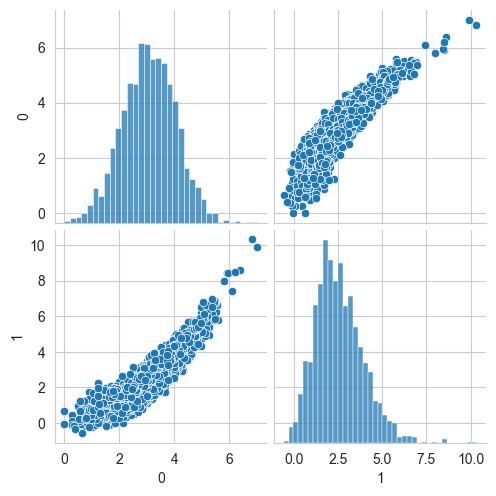

In [5]:
rng = np.random.RandomState(1)
nsample = 1000
shift = 1.0
X  = np.empty((nsample,2))
rnd  = rng.randn(1, nsample)
X[:,0]  = rnd - rnd.min()
X[:,1]  = 0.2*X[:,0]**2 + 0.3 * rng.randn(1, nsample)
Y  = np.empty((nsample,2))
rnd  = rng.randn(1, nsample)
Y[:,0]  = rnd - rnd.min()
Y[:,1]  = 0.2*Y[:,0]**2 + 0.3 * rng.randn(1, nsample) + shift
Z = np.concatenate((X,Y))
df_Z = pd.DataFrame(Z)
labels = np.concatenate((np.full(nsample,0), np.full(nsample, 1)))
# The data are correlated but not linearly
sb.pairplot(df_Z)
plt.show()

#### Spearman's rank correlation

Finds the R correlation between variable-pairs of ordinal data types. Variable-pairs are thena ble to be ranked according to the strength of the correlation between them. The assumptions are
- variables are ordinal
- variables are related non linearly
- data are non-normally distributed

The meanings for R are:
- R tends to 1  strongly correlated
- R = 0 no correlated
- R tends to -1 strongly anti-correlated

In [6]:
spearmanr_coefficient, p_value = spearmanr(Z)
print('Spearman rank coefficient is %0.3f' % spearmanr_coefficient)

Spearman rank coefficient is 0.876


The R value is closed to one. The two features are highly *correlated*.
The two classes overlap. One can plot the distribution of each class.

In [7]:
table = pd.crosstab(Z[:,0],Z[:,1])
chi2, p, dof, expected = chi2_contingency(table.values)
print('Chi square statistic %0.3f p_value %0.3f' % (chi2,p))

Chi square statistic 3996000.000 p_value 0.240


p > 0.05 means 95% confidence.
We can test if the second feature follows a normal-distribution. We can also use the Anderson-Darling test. First the first feature

In [8]:
anderson(Z[:,0], dist='norm')

AndersonResult(statistic=0.28671002178043636, critical_values=array([0.575, 0.655, 0.785, 0.916, 1.09 ]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=3.0672748205444367, scale=0.9768969574946749)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')

OK. The first feature is normaly-distrbution at 95% (p_value=0.286 < 0.785). For the second feature,

In [9]:
anderson(Z[:,1], dist='norm')

AndersonResult(statistic=10.177921841909438, critical_values=array([0.575, 0.655, 0.785, 0.916, 1.09 ]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=2.5770436897214735, scale=1.3572795692818245)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')

The second feature is definitively not normally-distributed.

In [10]:
from scipy.stats import shapiro
# The Shapiro-Wilk test tests the null hypothesis 
# that the data was drawn from a normal distribution.
# For N > 5000 the W test statistic is accurate but the p-value may not be.
# The chance of rejecting the null hypothesis when it is true 
# is close to 5% regardless of sample size.
# alpha = 0.05 (95% confidence intervall)
W, p_SW = shapiro(Z[:, 0])
print("W:", W)
print("p-value:", p_SW)  # check that p>0.05 for normal distribution

W: 0.9989649057388306
p-value: 0.30096909403800964


In [11]:
W, p_SW = shapiro(Z[:,1])
print("W:", W)
print("p-value:", p_SW)  # check that p>0.05 for normal distribution

W: 0.9696910381317139
p-value: 4.049990662628703e-20


The second feature is skewed (by construction) and the test confirms it (p-value<< 0.05).

In [12]:
def plot_histogram(X,Y):
    plt.subplots(figsize=(12, 5))
    plt.subplot(121)
    plt.hist(X[:,0],alpha=0.3,label='X')
    plt.hist(Y[:,0],alpha=0.3,label='Y')
    plt.title('Feature 1')
    plt.subplot(122)
    plt.hist(X[:,1],alpha=0.3,label='X')
    plt.hist(Y[:,1],alpha=0.3,label='Y')
    plt.legend(loc='upper right', fancybox=True, fontsize=8)
    plt.title('Feature 2')

KstestResult(statistic=0.043, pvalue=0.3136800387320582, statistic_location=2.6031589830297905, statistic_sign=-1)
KstestResult(statistic=0.313, pvalue=1.1286198577396754e-43, statistic_location=1.915855420957919, statistic_sign=1)


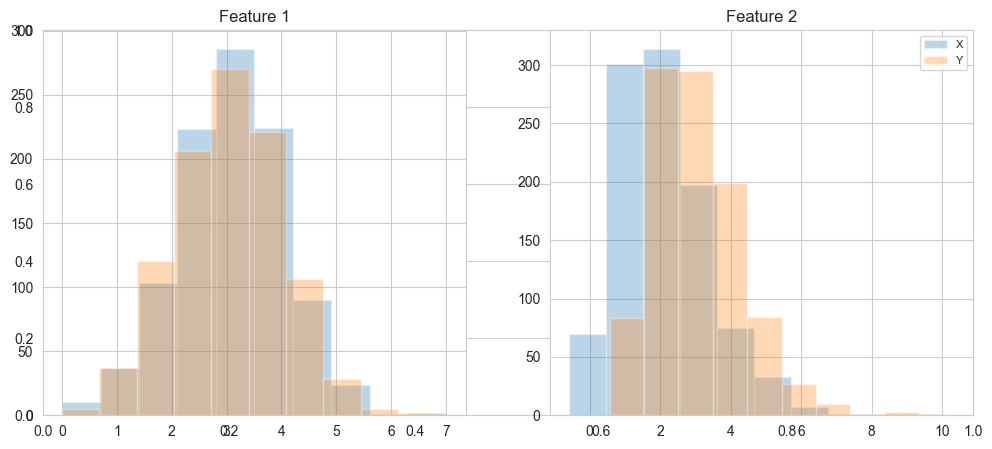

In [13]:
plot_histogram(X,Y)
print(ks_2samp(X[:,0],Y[:,0]))
print(ks_2samp(X[:,1],Y[:,1]))

There are significant overlaps in the feature value distrbution for both classes.

Feature engineering linearization: first shift to a minimum value of 1, then take the log10. The transformation is monotonic. It does not change the order.$$\log(X-\min(Z)+1)$$
$$\log(Y-\min(Z)+1)$$
What we have perform is a so-called Box-Cox transform of the data with first a shift to obtain positive data followed by a transform with $\lambda$ = 0.

In [14]:
Xl  = np.empty((nsample,2))
Xl[:,0]= X[:,0]
Xl[:,1] = np.log(X[:,1]-Z[:,1].min()+1.)
Yl  = np.empty((nsample,2))
Yl[:,0]= Y[:,0]
Yl[:,1] = np.log(Y[:,1]-Z[:,1].min()+1.)
Zl = np.concatenate((Xl,Yl))    

We can test if the two distributions are statistically distinct. The null-hypothesis is that the two samples are drawn from the same distribution with alpha = 0.05 (95%) to be compared to the p-value. We then can plot the histogram.

KstestResult(statistic=0.043, pvalue=0.3136800387320582, statistic_location=2.6031589830297905, statistic_sign=-1)
KstestResult(statistic=0.313, pvalue=1.1286198577396754e-43, statistic_location=1.2484915193827317, statistic_sign=1)


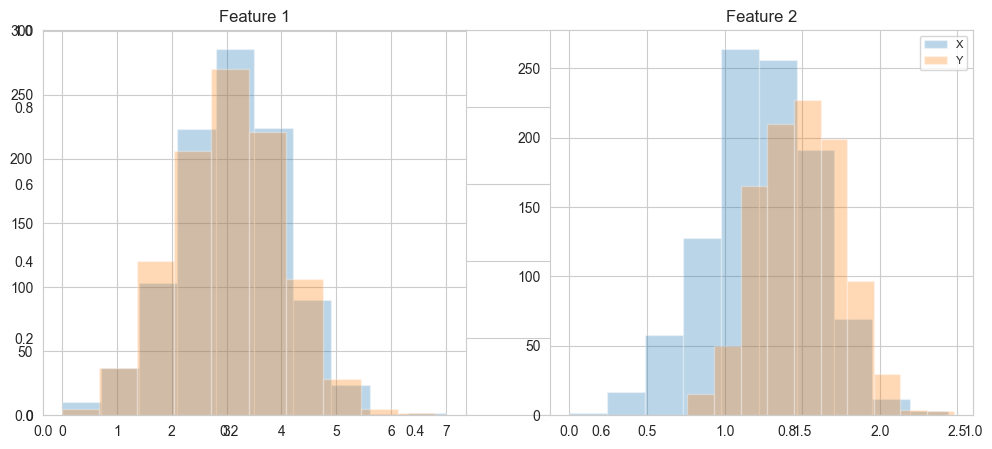

In [15]:
print(ks_2samp(Xl[:,0],Yl[:,0]))
print(ks_2samp(Xl[:,1],Yl[:,1]))
plot_histogram(Xl,Yl)

The linearization has increased the separation in the distribution for Feature 2. That was the intention.
We can compare to the use of the scipy Box-Cox transform with the log transform.
Box-Cox and other power transforms aim at make the data more normaly distributed. Instead here we aim quasi the contrary: we wish to separate the blended distributions of the two classes to ease further classification.

lambda from Box-Cox: 0.2868452665798857
AndersonResult(statistic=0.32573841104635903, critical_values=array([0.575, 0.655, 0.785, 0.916, 1.09 ]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=1.6992904635352253, scale=0.4899353864907393)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')
KstestResult(statistic=0.043, pvalue=0.3136800387320582, statistic_location=2.6031589830297905, statistic_sign=-1)
KstestResult(statistic=0.313, pvalue=1.1286198577396754e-43, statistic_location=1.5013071212052171, statistic_sign=1)


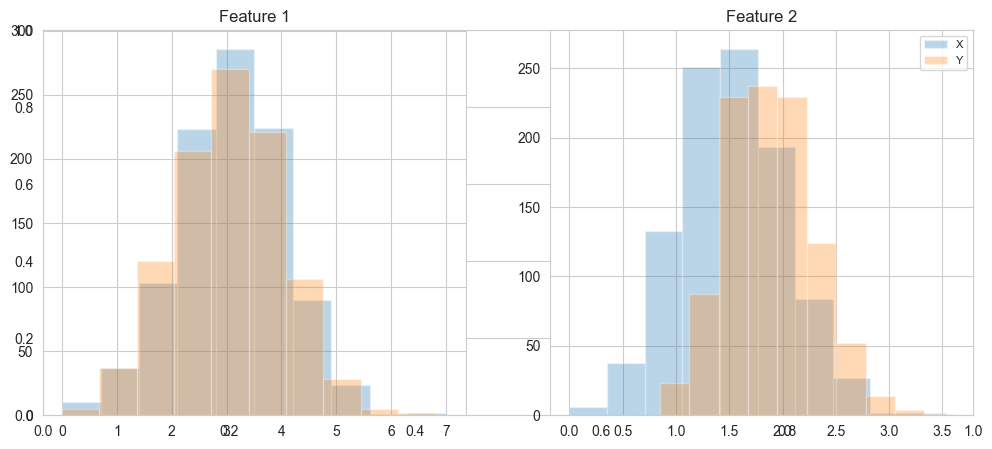

In [16]:
Zt,lbd = boxcox(Z[:,1]-Z[:,1].min()+1.)
# the term -Z[:,1].min()+1. ensures that we deal with positive values
print('lambda from Box-Cox:',lbd)
Xlbc  = np.empty((nsample,2))
Xlbc[:,0]= X[:,0]
Xlbc[:,1] = boxcox(X[:,1]-Z[:,1].min()+1.,lmbda=lbd)
Ylbc  = np.empty((nsample,2))
Ylbc[:,0]= Y[:,0]
Ylbc[:,1] = boxcox(Y[:,1]-Z[:,1].min()+1.,lmbda=lbd)
Zlbc = np.concatenate((Xlbc,Ylbc))
df_Zlbc = pd.DataFrame(Zlbc)
print(anderson(Zlbc[:,1], dist='norm'))
print(ks_2samp(Xlbc[:,0],Ylbc[:,0]))
print(ks_2samp(Xlbc[:,1],Ylbc[:,1]))
plot_histogram(Xlbc,Ylbc)

In [17]:
# Johnson 1949 transform
from scipy.stats import johnsonsu, johnsonsb

We perform a Principle Component Analysis with 2 components directly on the original data.

In [18]:
pca = PCA(n_components=2)
pca.fit(Z)
Zpca = pca.transform(Z)
Xpca = pca.transform(X)
Ypca = pca.transform(Y)

We print the variance ratio explained by each component.

In [19]:
print("Explained variance ratio")
print(pca.explained_variance_ratio_)
print("Eigenvectors (The sign can be opposite)")
comps = pd.DataFrame(pca.components_,columns=['Feature 1','Feature 2'])
comps

Explained variance ratio
[0.94597821 0.05402179]
Eigenvectors (The sign can be opposite)


,Feature 1,Feature 2
0,0.567472,0.823393
1,-0.823393,0.567472


<Axes: >

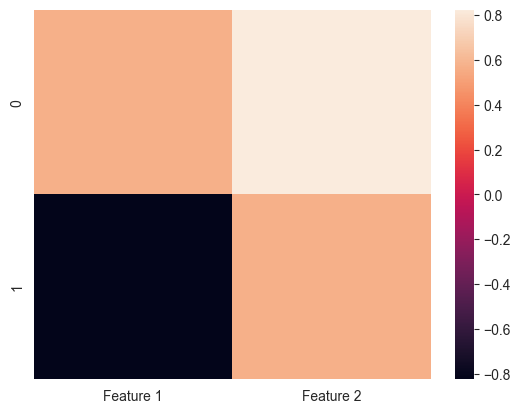

In [20]:
sb.heatmap(comps)

The first component explained close to 98% of the variance but it is the second component that separate the to classes.

We can also compute the eigenvalues

In [21]:
# Compute the eigenvalues
n_samples = X.shape[0]
X1 = np.copy(X)
X1 -= np.mean(X1, axis=0) #center the data and compute the sample covariance matrix.
cov_matrix = np.dot(X1.T, X1) / n_samples
print("Eigenvalues")
for eigenvector in pca.components_:
    print(np.dot(eigenvector.T, np.dot(cov_matrix, eigenvector)))

Eigenvalues
2.531714257979216
0.07550433729469583


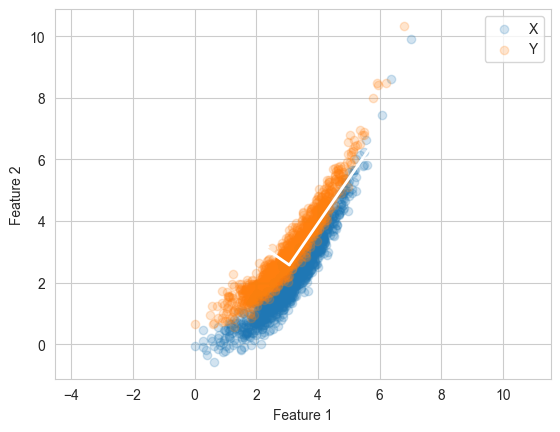

In [22]:
plot_data(X, Y, pca)

The arrows indicate the PCA components, which acts as the new axes (called principal axes). The original data will be reprojected on these axe. The two features are related by a nonlinear relationship. PCA works at best with features that are linearly related. Let's plot the PCA features.

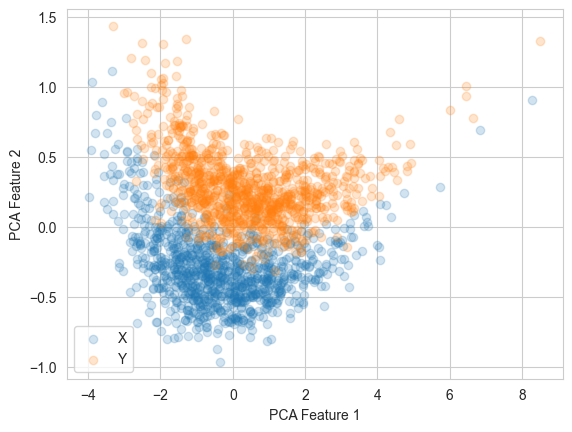

In [23]:
plot_transformed_data(Xpca,Ypca,'PCA')

There is a residual relationship between PCA feature 1 and PCA feature 2.
Let's run the PCA on the linearized data.

The PCA vectors now separate the classes. The largest variance still lie with the first feature. Let's see this with the histograms. Notice that the distributions are centered around zero.


KstestResult(statistic=0.194, pvalue=7.246822006432893e-17, statistic_location=-0.4300979150584426, statistic_sign=1)
KstestResult(statistic=0.785, pvalue=7.250751977715377e-306, statistic_location=-0.028118727416768286, statistic_sign=1)


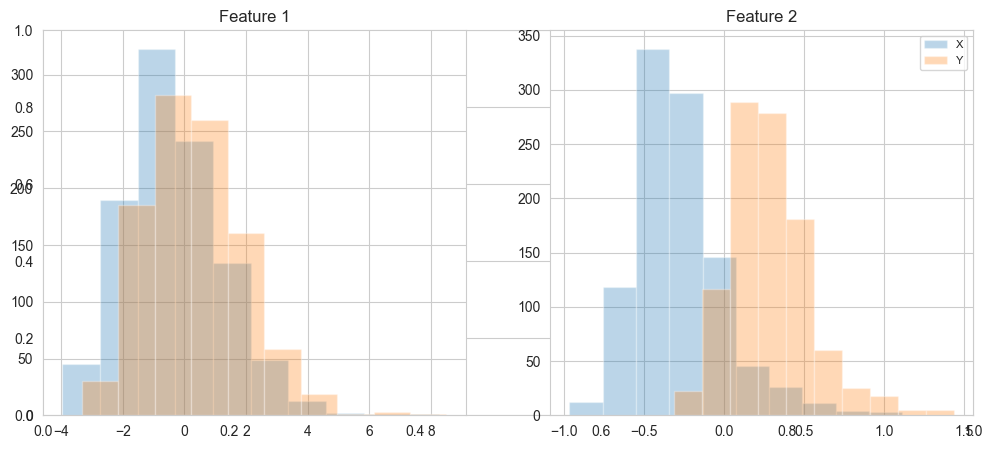

In [24]:
print(ks_2samp(Xpca[:,0],Ypca[:,0]))
print(ks_2samp(Xpca[:,1],Ypca[:,1]))
plot_histogram(Xpca,Ypca)

We perform the PCA on the linearized data.

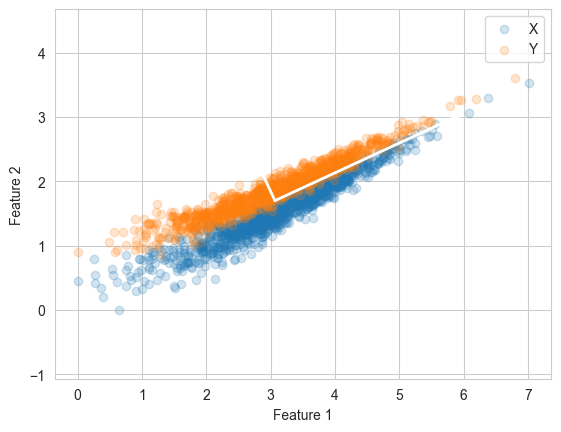

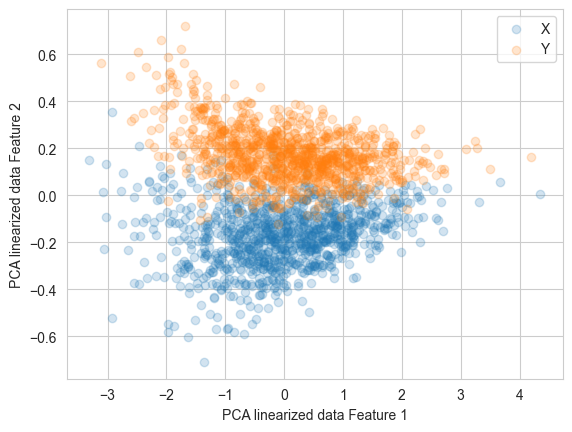

KstestResult(statistic=0.057, pvalue=0.07761108123267829, statistic_location=-0.15682439269158652, statistic_sign=1)
KstestResult(statistic=0.87, pvalue=0.0, statistic_location=0.023688603692232673, statistic_sign=1)


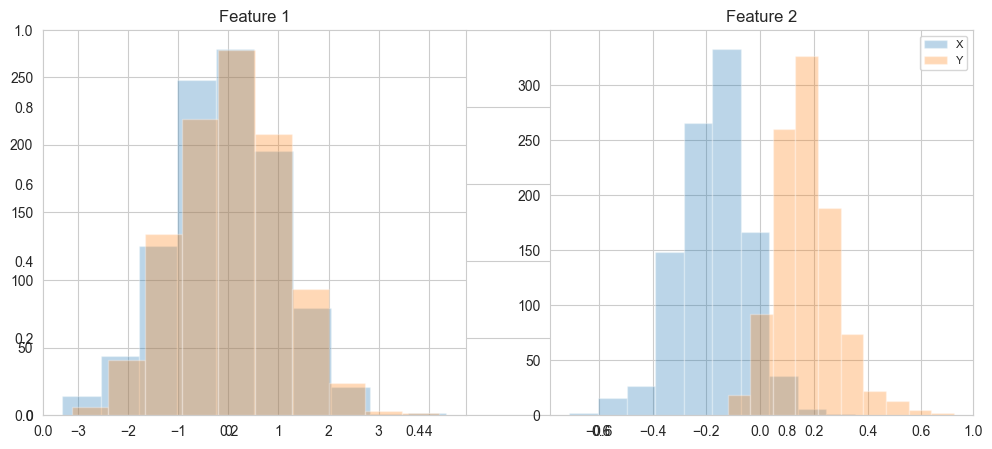

In [25]:
# after linearization with Box-Cox transform
pca.fit(Zlbc)
Zlpca = pca.transform(Zlbc)
Xlpca = pca.transform(Xlbc)
Ylpca = pca.transform(Ylbc)
plot_data(Xlbc,Ylbc,pca)
plot_transformed_data(Xlpca,Ylpca,'PCA linearized data')
print(ks_2samp(Xlpca[:,0],Ylpca[:,0]))
print(ks_2samp(Xlpca[:,1],Ylpca[:,1]))
plot_histogram(Xlpca,Ylpca)

PCA feature 2 after linearization shows that the class distrbutions are clearly separated.  Since to get the best results from the machine learning algorithms as possible, we should only use features that correlate strongly with the output values, here fearure 2. We want to make the "life" of the machine learning algorithm as simple as possible. Including useless features can on the other hand harm the accuracy of the system.

### Feature engineering strategies
- Adding or dropping features: one chooses the features that have the most signal.
- Combining multiple features into one feature: this is what PCA or FA is doing. The goal is to represent the data in the simplest way as possible.
- Binning: one replaces an exact numerical measurement with a more broad catagory. For example, ages can be binned into catergories like: infant, adolescent, adult, senior.
- One-hot encoding: it is a way to represent categorical data as number without creating
- Avoid the "curse" of Dimensionality: as the number of dimensions (or features) in the data increases, the number of data points required to build a good model grows exponentially. One should only include the features that have the most selective/predictive information and exclude those that are not predictive.
- Domain knowledge/expertise is key in feature engineering.

We run the classifier for different data. First directly on the original data

In [26]:
result = [classify(Z)]

On the PCA-transformed of the original data

In [27]:
result.append(classify(Zpca))

Finally on the linearized and PCA-transformed data

In [28]:
result.append(classify(Zlpca))

In [29]:
methods = pd.DataFrame(['original','PCA','linearPCA'])
df=pd.DataFrame(result)
df2=pd.concat([methods,df],axis='columns')
df2.columns=['Method','CV Train Accuracy', 'CV Test Accuracy']
df2

,Method,CV Train Accuracy,CV Test Accuracy
0,original,0.785375,0.777
1,PCA,0.916625,0.913
2,linearPCA,0.934500,0.929


The model train and test accuracy are close to each other and improve as we perform more feature engineering.

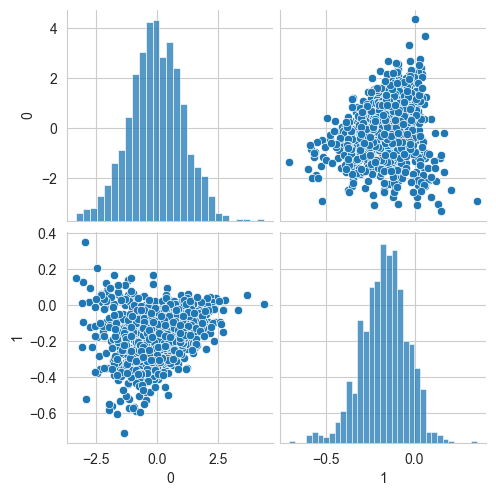

In [30]:
nbins = 15
nrandom =1000
ind = np.arange(0,nbins,1)
Xrpca= np.empty((nrandom,2))
Yrpca= np.empty((nrandom,2))

def random_dist(pca_dist):
    rpca= np.empty((nrandom,2))
    for i,dist in enumerate(pca_dist):
        px, x= np.histogram(dist,nbins,density=True)
        px = px/px.sum()
        idx =rv_discrete(values=(ind,px)).rvs(size=nrandom) 
        dx  = x[1]-x[0]
        xval = x[0:nbins]
        rpca[:,i] = xval[idx]+np.random.random(nrandom)*dx
    return rpca

Xrpca = random_dist([Xlpca[:,0],Xlpca[:,1]])
Yrpca = random_dist([Ylpca[:,0],Ylpca[:,1]])
Zrpca = np.concatenate((Xrpca,Yrpca))
df_Zrpca = pd.DataFrame(Zrpca)
df_Zrpca.columns = ['PCA 1','PCA 2']
df_Xlpca = pd.DataFrame(Xlpca)
sb.pairplot(df_Xlpca)
plt.show()

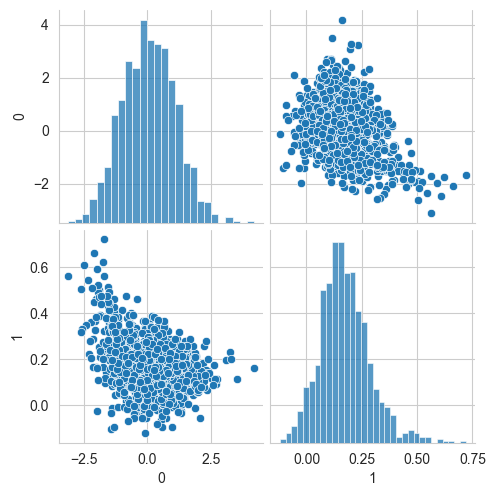

In [31]:
df_Ylpca = pd.DataFrame(Ylpca)
sb.pairplot(df_Ylpca)
plt.show()

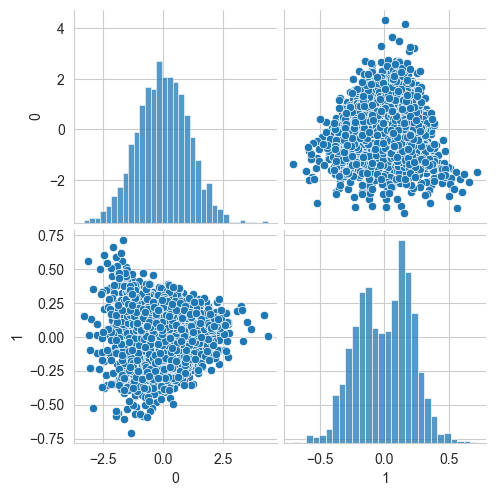

In [32]:
df_Zlpca = pd.DataFrame(Zlpca)
sb.pairplot(df_Zlpca)
plt.show()

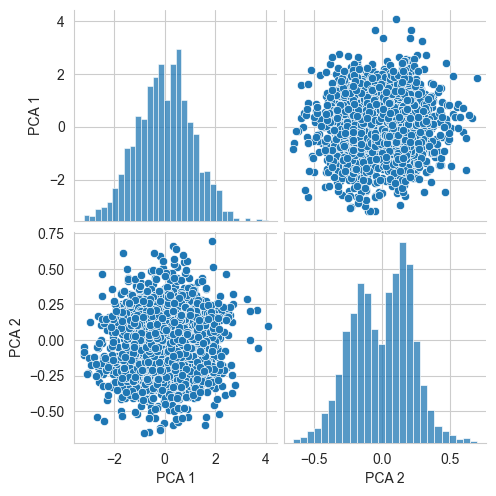

In [33]:
sb.pairplot(df_Zrpca)

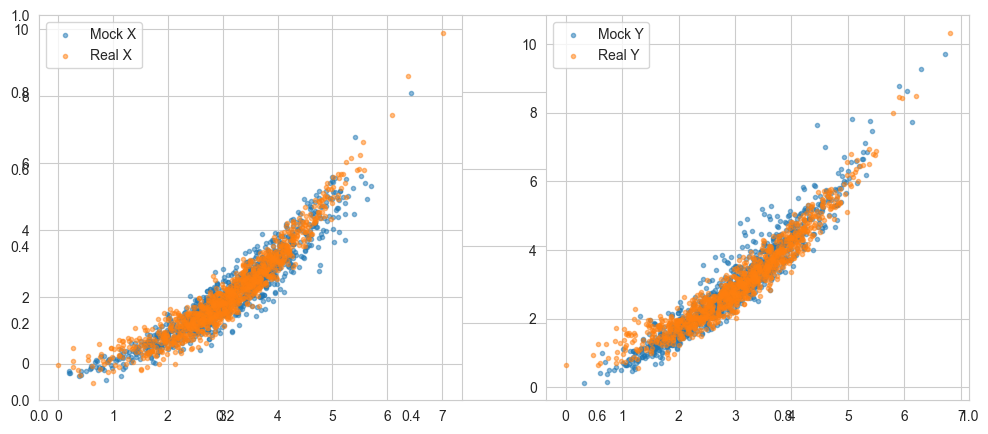

In [34]:
# apply inverse PCA transform
Xr = pca.inverse_transform(Xrpca)
Yr = pca.inverse_transform(Yrpca)
# inverse Box-Cox and adding back the constant term
Xr[:,1] = inv_boxcox(Xr[:,1],lbd)+Z[:,1].min()-1
Yr[:,1] = inv_boxcox(Yr[:,1],lbd)+Z[:,1].min()-1
Zr = np.concatenate((Xr,Yr))

Ztot = np.concatenate((Zlpca,Zrpca))
labels = np.concatenate((np.full(nrandom,0),np.full(nrandom,1)))

ax1 = plt.subplots(figsize=(12, 5))
ax1 = plt.subplot(121)
plt.scatter(Xr[:,0],Xr[:,1], label='Mock X',alpha=0.5,marker=".")
plt.scatter(X[:, 0], X[:, 1], label='Real X',alpha=0.5,marker="." )
plt.legend(frameon=True)
ax2 = plt.subplot(122)
plt.scatter(Yr[:,0],Yr[:,1], label='Mock Y',alpha=0.5,marker=".")
plt.scatter(Y[:,0],Y[:,1], label='Real Y',alpha=0.5,marker=".")
plt.legend(frameon=True)
plt.show()


(-1.0, 11.0)

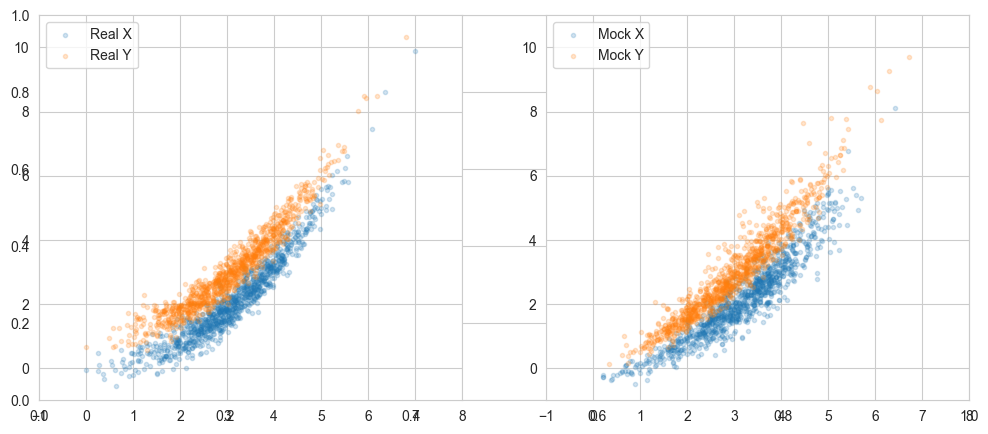

In [35]:
ax1 = plt.subplots(figsize=(12, 5))
ax1 = plt.subplot(121)
plt.scatter(X[:,0],X[:,1], label='Real X',alpha=0.2,marker=".")
plt.scatter(Y[:,0],Y[:,1], label='Real Y',alpha=0.2,marker=".")
plt.legend(frameon=True)
plt.xlim(-1,8)
plt.ylim(-1,11)
ax2 = plt.subplot(122)
plt.scatter(Xr[:,0],Xr[:,1], label='Mock X',alpha=0.2,marker=".")
plt.scatter(Yr[:,0],Yr[:,1], label='Mock Y',alpha=0.2,marker=".")
plt.legend(frameon=True)
plt.xlim(-1,8)
plt.ylim(-1,11)

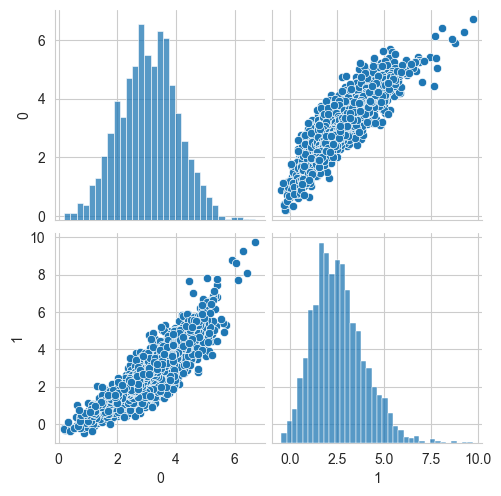

In [36]:
df_Zr = pd.DataFrame(Zr)
sb.pairplot(df_Zr)

In [37]:
print("Classification on the extra Data")
print("CV Train & Test Accuracy")
df3 = pd.DataFrame([classify(Zrpca)])
df3.columns = ['CV Train Accuracy', 'CV Test Accuracy']
df3

Classification on the extra Data
CV Train & Test Accuracy


,CV Train Accuracy,CV Test Accuracy
0,0.9365,0.9315


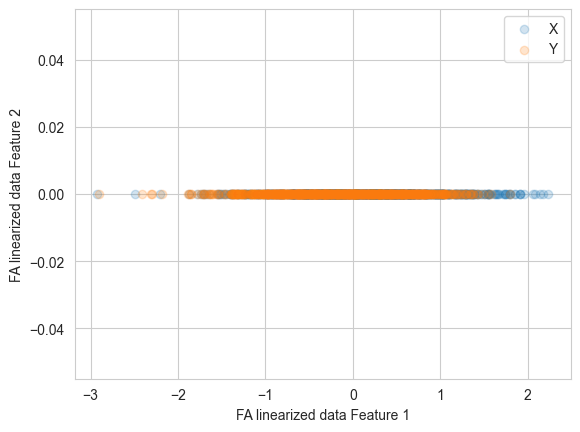

In [38]:
fa= FactorAnalysis(n_components=2, max_iter=50,copy=True,svd_method='lapack')
fa.fit(Zlbc)
Zfa = fa.transform(Zlbc)
Zlfa = fa.transform(Zlbc)
Xlfa = fa.transform(Xlbc)
Ylfa = fa.transform(Ylbc)
plot_transformed_data(Xlfa,Ylfa,'FA linearized data')

The Factor Analysis transformation failed to separate the two features.

Another example using the random dataset generator in scikit-learn

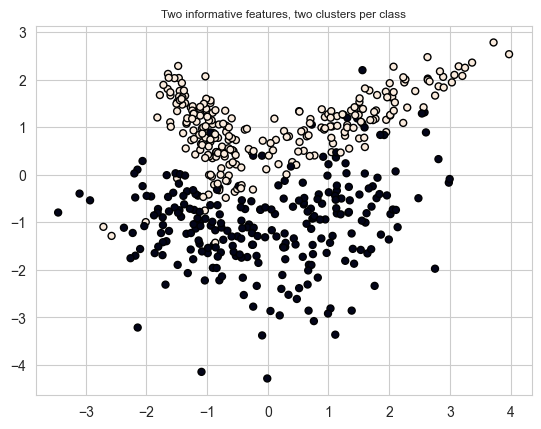

In [39]:
from sklearn.datasets import make_classification 
#help("sklearn.datasets.make_classification")
plt.title("Two informative features, two clusters per class",
          fontsize='small')
nsamples=500
X2, Y2 = make_classification(n_samples=nsamples,n_features=2, n_redundant=0,
                             n_informative=2,random_state=1999)
plt.scatter(X2[:, 0], X2[:, 1], marker='o', c=Y2,
            s=25, edgecolor='k')
plt.show()

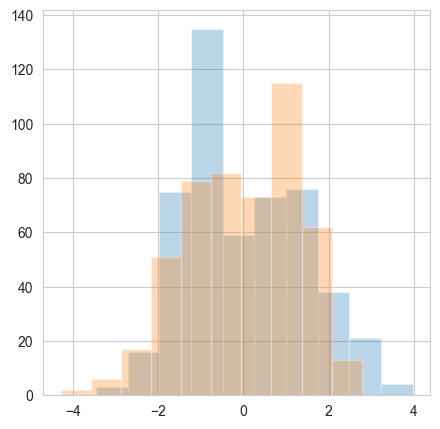

In [40]:
plt.subplots(figsize=(5, 5))
plt.subplot(111)
plt.hist(X2[:,0],alpha=0.3,label='Feature 1')
plt.hist(X2[:,1],alpha=0.3,label='Feature 2')
plt.show()

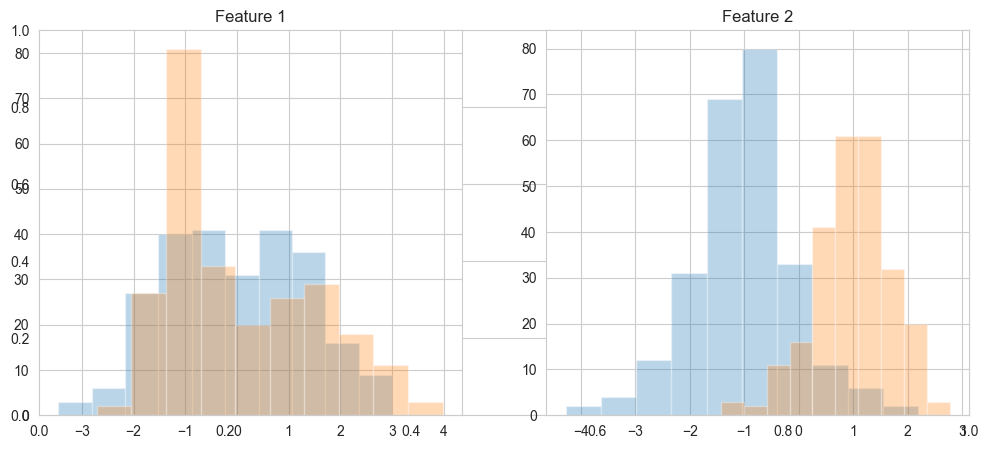

In [41]:
plt.subplots(figsize=(12, 5))
plt.subplot(121)
plt.hist(X2[Y2 == 0,0],alpha=0.3)
plt.hist(X2[Y2 == 1,0],alpha=0.3)
plt.title('Feature 1')
plt.subplot(122)
plt.hist(X2[Y2 == 0,1],alpha=0.3)
plt.hist(X2[Y2 == 1,1],alpha=0.3)
plt.title('Feature 2')
plt.show()

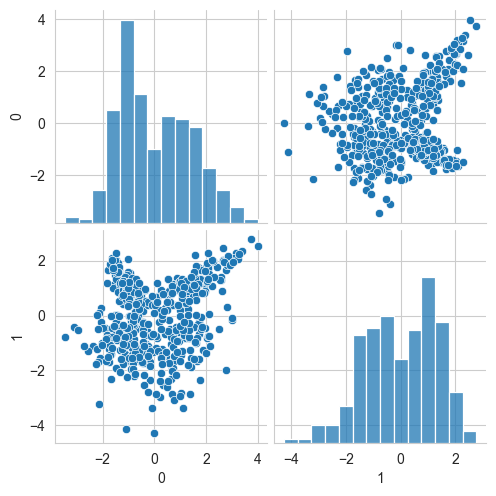

In [42]:
Z3 = X2
df_Z3=pd.DataFrame(Z3)
sb.pairplot(df_Z3)
plt.show()

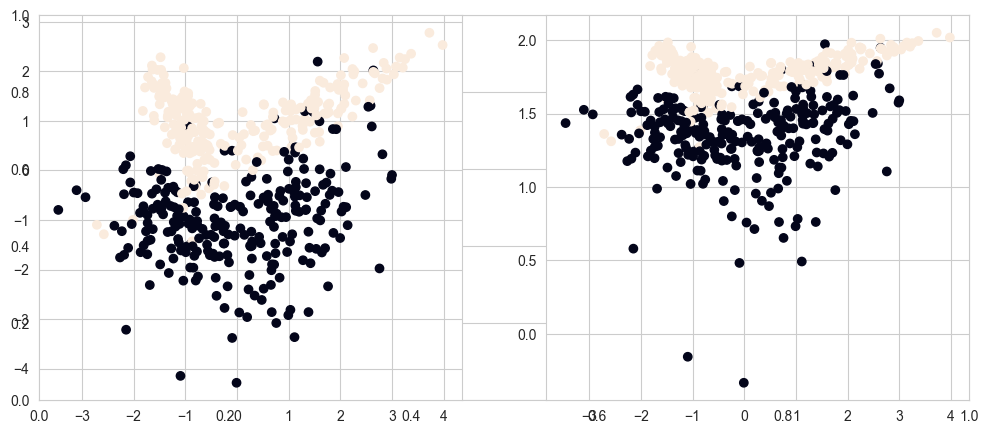

In [43]:
Z3lbc  = np.empty((nsamples,2))
Z3lbc[:,0]= Z3[:,0]
Z3lbc[:,1]= np.log(Z3[:,1]+5.) # Box-Cox type transform
plt.subplots(figsize=(12, 5))
plt.subplot(121)
plt.scatter(Z3[:,0],Z3[:,1], c=Y2)
plt.subplot(122)
plt.scatter(Z3lbc[:,0],Z3lbc[:,1], c=Y2)
plt.show()

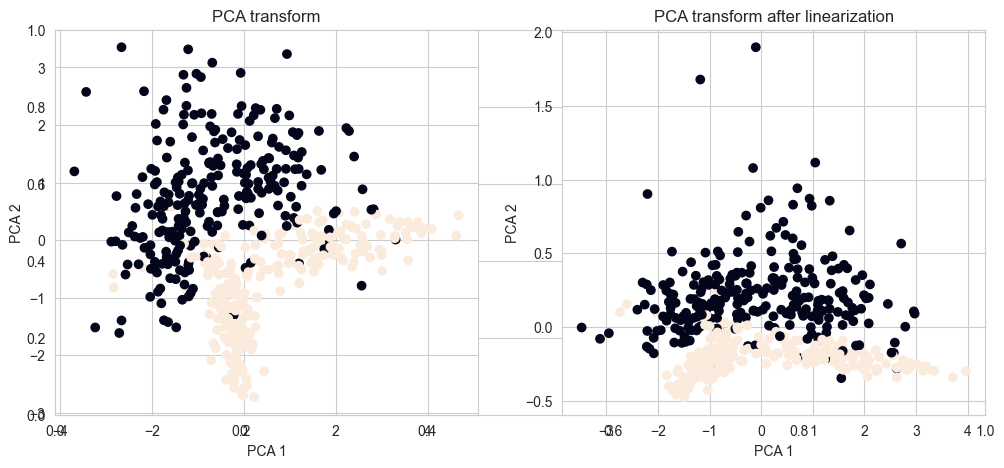

In [44]:
pca.fit(Z3)
Z3pca = pca.transform(Z3)
pca.fit(Z3lbc)
Z3lpca = pca.transform(Z3lbc)
plt.subplots(figsize=(12, 5))
plt.subplot(121)
plt.scatter(Z3pca[:,0],Z3pca[:,1],c=Y2)
plt.title('PCA transform')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.subplot(122)
plt.scatter(Z3lpca[:,0],Z3lpca[:,1],c=Y2)
plt.title('PCA transform after linearization')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

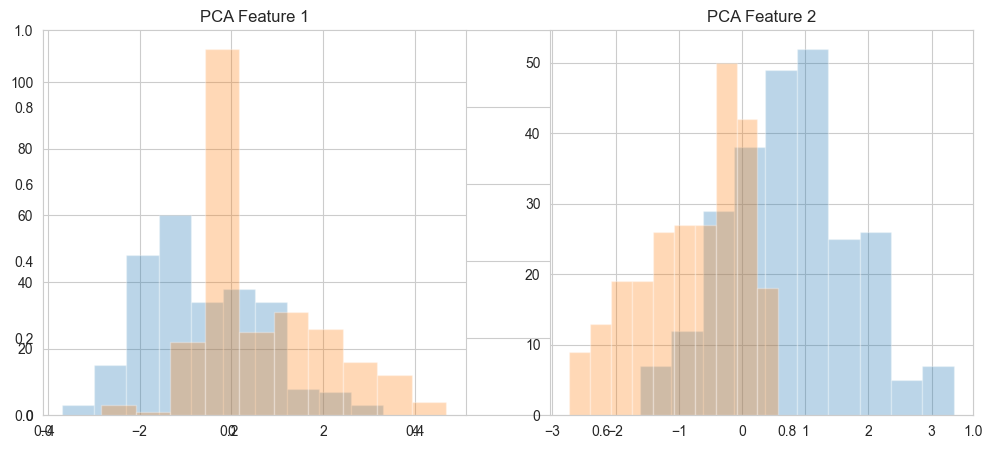

In [45]:
plt.subplots(figsize=(12, 5))
plt.subplot(121)
plt.hist(Z3pca[Y2 == 0,0],alpha=0.3)
plt.hist(Z3pca[Y2 == 1,0],alpha=0.3)
plt.title('PCA Feature 1')
plt.subplot(122)
plt.hist(Z3pca[Y2 == 0,1],alpha=0.3)
plt.hist(Z3pca[Y2 == 1,1],alpha=0.3)
plt.title('PCA Feature 2')
plt.show()

The PCA feature distributions are not clearly separated but are seen in the two features. 

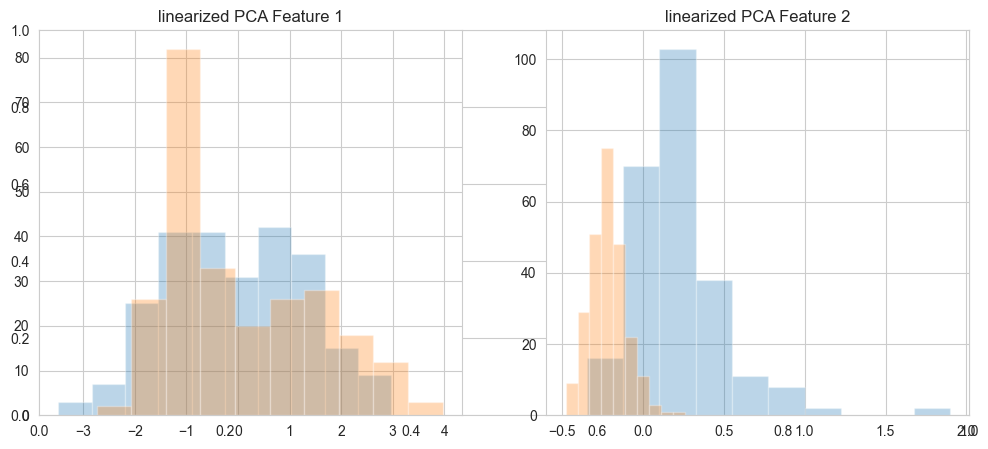

In [46]:
plt.subplots(figsize=(12, 5))
plt.subplot(121)
plt.hist(Z3lpca[Y2 == 0,0],alpha=0.3)
plt.hist(Z3lpca[Y2 == 1,0],alpha=0.3)
plt.title('linearized PCA Feature 1')
plt.subplot(122)
plt.hist(Z3lpca[Y2 == 0,1],alpha=0.3)
plt.hist(Z3lpca[Y2 == 1,1],alpha=0.3)
plt.title('linearized PCA Feature 2')
plt.show()

In [47]:
labels = Y2
result=[classify(Z3)]

In [48]:
result.append(classify(Z3pca))

In [49]:
result.append(classify(Z3lpca))

In [50]:
methods = pd.DataFrame(['original','PCA','linearPCA'])
df3=pd.DataFrame(result)
df3=pd.concat([methods,df3],axis='columns')
df3.columns=['Method','CV Train Accuracy', 'CV Test Accuracy']
df3

,Method,CV Train Accuracy,CV Test Accuracy
0,original,0.9050,0.900
1,PCA,0.9415,0.910
2,linearPCA,0.9175,0.902


The better success of the classification using PCA transformed data with linearization stems from the fact that in this case both PCA features can be used to classify.

### Conclusion

- The improvement from using the original data to using the PCA-transformed data is significant. An ultimate higher accuracy is obtained by first linearizing the data before applying the PCA transform. The PCA-transformation may not help all the time but it is worth to spend a moment to test it in our classification projects.
- The combination of the Box-Cox, scaling, and a PCA transform provides a way to obtain quasi-uncorrelated marginal distributions that will help generating random samplings. The sampling of the original distribution is done by performing the inverse transforms. 
- One should try different transform. Depending on the data at hand, a direct PCA transform could provide the highest gain in classification accuracy.
- The sampling of the distributions can be employed to generate artificial data and augment the data for subsequent training of machine-learning algorithms.

### Afterthoughts

The PCA components or the latent (i.e. not observable in the statistical vocabulary) variables in the Factor Analysis may have indeed a meaning for an expert. As a simple example, features like the income, the leisure budget, and the car budget should be correlated and could be factored into a social wellness index. Having less features helps to avoid the "curse of dimensionality".

In physical science many variables are related to each other, in fact this is the aim of the researchers to find these relationships. It is thus not surprising that a PCA/FA would reveal tightly related (correlated in the statistical sense) variables that can be grouped into PCA components or FA factors. A PCA/FA/ICA not only helps us in remedying the curse of dimensionality in further machine learning analysis (regression, classification) but it also provides insights into the relationships within the data without reference to any known labels. 